## AIM : To make a predictive model to predict if the customer will respond positively to the campaign or not.

### NOTES ABOUT RESPONSE MODELS:
#### Targeting the Right Prospects: What are Response Models?

Response models use data mining to find similarities between responders from previous marketing campaigns to predict who is likely or not likely to respond to a future campaign. The model is then scored against the prospects of the new campaign and a marketer can choose to mail only those people that are most likely to purchase. This increases conversions and decreases costs by only mailing to those most likely to respond.

- Direct Marketing Models: Good, Better, Best

Not all models are created equal. Here’s a quick summary of different types of direct marketing models:

#### GOOD. Recency, Frequency, Monetary (RFM) models:

- simple, better than not modeling

- Though very basic, many marketers still rely on RFM models. Technically RFM models aren’t actually response models since they are descriptive but not truly predictive. This method emphasizes customer behavior and segments by how recently a customer purchased, how often they purchase, and how much they spend.

- RFM can identify good customers and provide a lift in response rates versus not using any targeting. Another benefit is that it is both simple and descriptive, so it is easily understood by business people.

- Unfortunately, RFM doesn’t take into account life stage and assumes that customers are likely to continue to respond the same way. If RFM is the only targeting method, the most attractive segments are likely to be over-marketed to at the expense of other segments that could be invested in.

#### BETTER. Traditional Response or Regression Models: 
- more sophisticated and predictive than RFM

- Regression models determine the correlation between variables. Unlike RFM models, regression takes into account that scores can quickly change when combined with other variables. 

- The model is developed specifically to predict a desired behavior, such as response. Response models require both responder and non-responder data to identify patterns of those likely to respond to a marketing campaign.

- This is by far the most widely used approach for marketers and has been a mainstay of predictive analytics for decades.

#### BEST. Multi-Channel Customer Level Response Models: 
- A New Approach that Outperforms Traditional

- This innovative approach identifies not only those prospects most likely to purchase, but also which marketing channel they are most likely to respond to. This allows marketers to optimize their marketing budgets most effectively by contacting the prospect in the channel(s) they prefer and are most likely to be moved by.

- Multi-Channel Customer Level Response Models are different from traditional response models in that all of a prospect’s known activity is taken into account – email opens, web browsing, display ad click-throughs, mobile, purchase behavior – and not just direct mail behavior. With a more holistic view of the customer, a marketer can create the ideal customer contact strategy for each customer.

- In a recent head-to-head in the mail test with a major cataloger, the Multi-Channel Customer Level Response Model outperformed the traditional response model with a more than +14% lift in response rate. This increase translates into millions of dollars in new annual revenue at the current spend. A new subject line or pretty picture won’t drive revenue like that!

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\RAHUL CHHIKARA\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importing Data

In [55]:
df=pd.read_csv("bank_marketing.csv")
df.head()

,age,job,salary,marital,education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,58,management,100000,married,tertiary,yes,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,60000,single,secondary,yes,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,120000,married,secondary,yes,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,20000,married,unknown,no,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,0,single,unknown,no,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [67]:
#Labelling response column to 1,0 values which is orginally stored as yes,no
df['response'] = df['response'].str.lower().replace({'yes': 1, 'no': 0})

In [45]:
#Labelling y column to 1,0 values which is orginally stored as yes,no
df['response'] = df['response'].str.lower().replace({'yes': 1, 'no': 0})

### UDF's

In [68]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.nunique(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'UNIQUE', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [69]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [70]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [112]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

### Data Inspection

In [71]:
# check the metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 24060 to 45210
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        8257 non-null   int64 
 1   job        8257 non-null   object
 2   salary     8257 non-null   int64 
 3   marital    8257 non-null   object
 4   education  8257 non-null   object
 5   targeted   8257 non-null   object
 6   default    8257 non-null   object
 7   balance    8257 non-null   int64 
 8   housing    8257 non-null   object
 9   loan       8257 non-null   object
 10  contact    8257 non-null   object
 11  day        8257 non-null   int64 
 12  month      8257 non-null   object
 13  duration   8257 non-null   int64 
 14  campaign   8257 non-null   int64 
 15  pdays      8257 non-null   int64 
 16  previous   8257 non-null   int64 
 17  poutcome   8257 non-null   object
 18  response   8257 non-null   int64 
dtypes: int64(9), object(10)
memory usage: 1.3+ MB


### Describe the pdays column, make note of the mean, median and minimum values. Anything fishy in the values?

In [72]:
df.pdays.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
salary,45211.0,57006.171065,32085.718415,0.0,20000.0,60000.0,70000.0,120000.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


#### >>> It seems pdays column contains mostly -ve values. 
#### >>> Pdays means number of days that passed by after the client was last contacted from a previous campaign.
#### >>> No of days can't be negative.

### Describe the pdays column again, this time limiting yourself to the relevant values of pdays. How different are the mean and the median values?

In [73]:
df=df[df.pdays > 0]
df.shape

(8257, 19)

In [74]:
df.pdays.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

### Separating Categorical and Numerical Data

In [75]:
# separate the categorical and continuous variable names
num_feature = [key for key in dict(df.dtypes) 
                     if dict(df.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_feature = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]

In [76]:
# print the variable names in both the variables
print(num_feature)
print(cat_feature)

['age', 'salary', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'response']
['job', 'marital', 'education', 'targeted', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [77]:
# get the dataframe of only continuous variables
df_num = df[num_feature]
df_num.head()

,age,salary,balance,day,duration,campaign,pdays,previous,response
24060,33,50000,882,21,39,1,151,3,0
24062,42,50000,-247,21,519,1,166,1,1
24064,33,70000,3444,21,144,1,91,4,1
24072,36,100000,2415,22,73,1,86,4,0
24077,36,100000,0,23,140,1,143,3,1


In [81]:
# get the data audit report for all the numeric variables
num_summary = df_num.apply(continuous_var_summary)
num_summary.T

,N,NMISS,UNIQUE,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,8257.0,0.0,72.0,338150.0,40.953131,38.0,11.425180,1.305347e+02,18.0,23.00,27.0,29.0,33.0,38.0,48.0,57.0,61.0,77.00,93.0
salary,8257.0,0.0,11.0,475306000.0,57564.006298,60000.0,31791.407761,1.010694e+09,0.0,4000.00,8000.0,20000.0,20000.0,60000.0,70000.0,100000.0,100000.0,120000.00,120000.0
balance,8257.0,0.0,3176.0,12855159.0,1556.880102,602.0,3060.593186,9.367231e+06,-1884.0,-480.00,-56.0,0.0,168.0,602.0,1743.0,4012.0,6248.6,12887.36,81204.0
day,8257.0,0.0,31.0,117986.0,14.289209,14.0,7.919176,6.271334e+01,1.0,1.00,2.0,4.0,7.0,14.0,20.0,27.0,29.0,30.00,31.0
duration,8257.0,0.0,986.0,2147800.0,260.118687,193.0,235.208105,5.532285e+04,1.0,11.00,39.0,65.6,113.0,193.0,324.0,531.0,707.0,1182.88,2219.0
campaign,8257.0,0.0,16.0,16978.0,2.056195,2.0,1.561169,2.437249e+00,1.0,1.00,1.0,1.0,1.0,2.0,2.0,4.0,5.0,8.00,16.0
pdays,8257.0,0.0,558.0,1854338.0,224.577692,194.0,115.344035,1.330425e+04,1.0,7.56,79.0,91.0,133.0,194.0,327.0,362.4,370.0,531.44,871.0
previous,8257.0,0.0,40.0,26237.0,3.177546,2.0,4.560820,2.080108e+01,1.0,1.00,1.0,1.0,1.0,2.0,4.0,6.0,9.0,17.00,275.0
response,8257.0,0.0,2.0,1905.0,0.230713,0.0,0.421315,1.775062e-01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.0


In [79]:
# get the dataframe of only categorical variables
df_cat = df[cat_feature]
df_cat.head()

,job,marital,education,targeted,default,housing,loan,contact,month,poutcome
24060,admin.,married,tertiary,yes,no,no,no,telephone,oct,failure
24062,admin.,single,secondary,yes,no,yes,yes,telephone,oct,other
24064,services,married,secondary,yes,no,yes,no,telephone,oct,failure
24072,management,married,tertiary,yes,no,yes,no,telephone,oct,other
24077,management,married,tertiary,yes,no,yes,no,telephone,oct,failure


In [80]:
# get the data audit report for all the categorical variables
cat_summary = df_cat.apply(categorical_var_summary)
cat_summary

,job,marital,education,targeted,default,housing,loan,contact,month,poutcome
N,8257,8257,8257,8257,8257,8257,8257,8257,8257,8257
NMISS,0,0,0,0,0,0,0,0,0,0
MODE,management,married,secondary,yes,no,yes,no,cellular,may,failure
FREQ,1826,4745,4254,6613,8200,5142,7134,7556,2514,4901
PERCENT,22.11,57.47,51.52,80.09,99.31,62.27,86.4,91.51,30.45,59.36


### Data Preparation

Since there is no missing values, no need to impute any values.
But there are outliers in data which can be seen on comparing the 99th percentile and the maximum value.

In [82]:
# Handling Outliers
df_num = df_num.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [83]:
# get the data audit report for all the numeric variables
num_summary = df_num.apply(continuous_var_summary)
num_summary.T

,N,NMISS,UNIQUE,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,8257.0,0.0,55.0,3.380130e+05,40.936539,38.0,11.264293,1.268843e+02,23.00,23.0000,27.0,29.0,33.0,38.0,48.0,57.0,61.0,77.0000,77.00
salary,8257.0,0.0,10.0,4.754380e+08,57579.992733,60000.0,31763.447480,1.008917e+09,4000.00,4000.0000,8000.0,20000.0,20000.0,60000.0,70000.0,100000.0,100000.0,120000.0000,120000.00
balance,8257.0,0.0,3030.0,1.217690e+07,1474.736573,602.0,2314.583521,5.357297e+06,-480.00,-480.0000,-56.0,0.0,168.0,602.0,1743.0,4012.0,6248.6,12870.3584,12887.36
day,8257.0,0.0,30.0,1.179530e+05,14.285213,14.0,7.910988,6.258374e+01,1.00,1.0000,2.0,4.0,7.0,14.0,20.0,27.0,29.0,30.0000,30.00
duration,8257.0,0.0,900.0,2.123312e+06,257.152966,193.0,219.547526,4.820112e+04,11.00,11.0000,39.0,65.6,113.0,193.0,324.0,531.0,707.0,1182.3872,1182.88
campaign,8257.0,0.0,8.0,1.683900e+04,2.039361,2.0,1.475913,2.178320e+00,1.00,1.0000,1.0,1.0,1.0,2.0,2.0,4.0,5.0,8.0000,8.00
pdays,8257.0,0.0,481.0,1.842974e+06,223.201405,194.0,110.003364,1.210074e+04,7.56,7.8064,79.0,91.0,133.0,194.0,327.0,362.4,370.0,531.1936,531.44
previous,8257.0,0.0,17.0,2.531400e+04,3.065762,2.0,2.887198,8.335912e+00,1.00,1.0000,1.0,1.0,1.0,2.0,4.0,6.0,9.0,17.0000,17.00
response,8257.0,0.0,2.0,1.905000e+03,0.230713,0.0,0.421315,1.775062e-01,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0000,1.00


## EDA

### Plot a horizontal bar graph with the median values of balance for each education level value. Which group has the highest median?

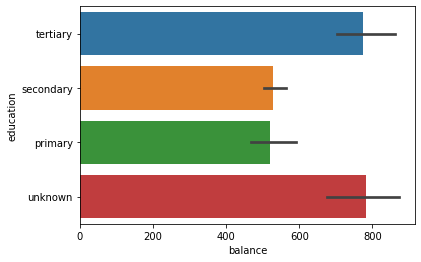

In [84]:
sn.barplot(x="balance", y="education", estimator=np.median, data=df)

#### >>> Unknown Education has highest median.

### Plotting response variable with all other Categorical Variables

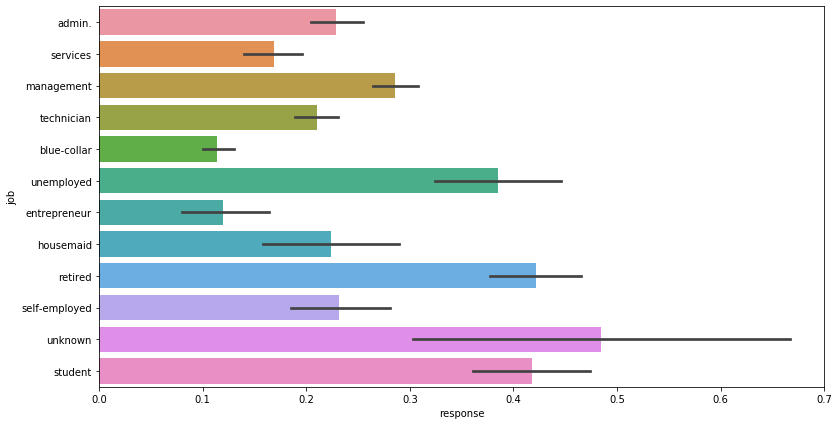

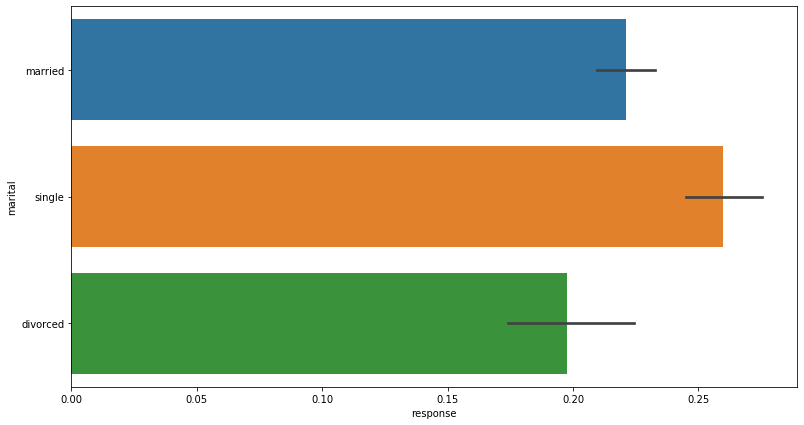

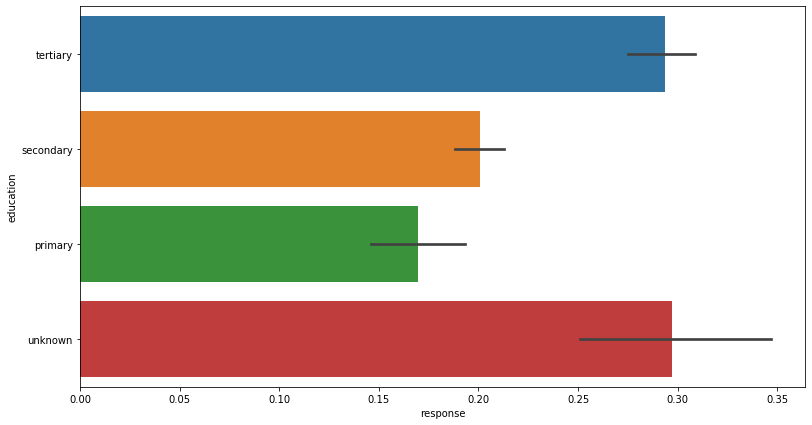

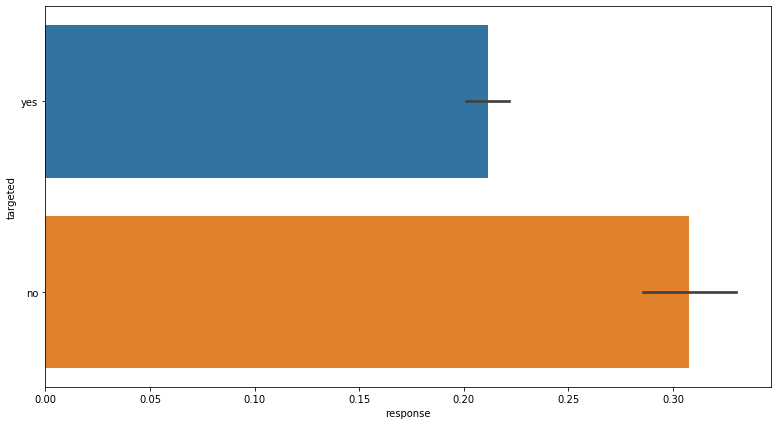

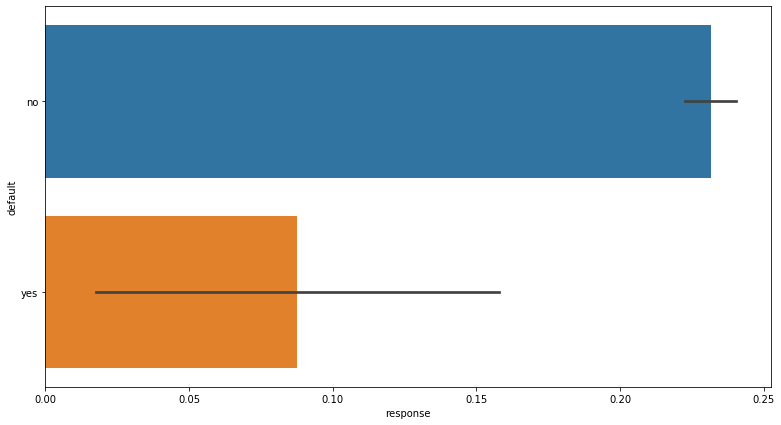

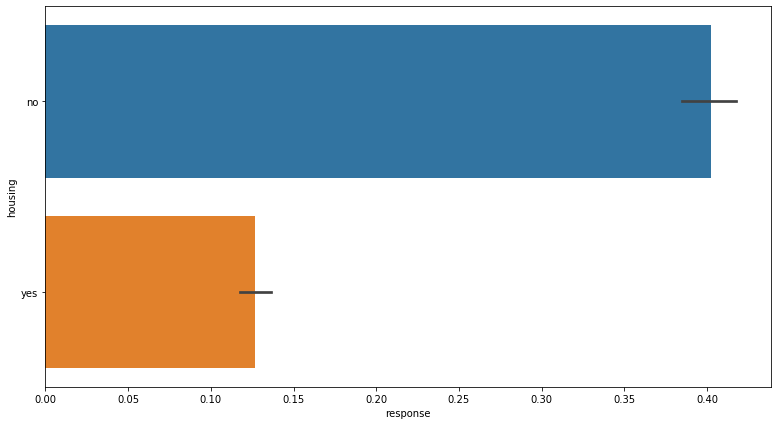

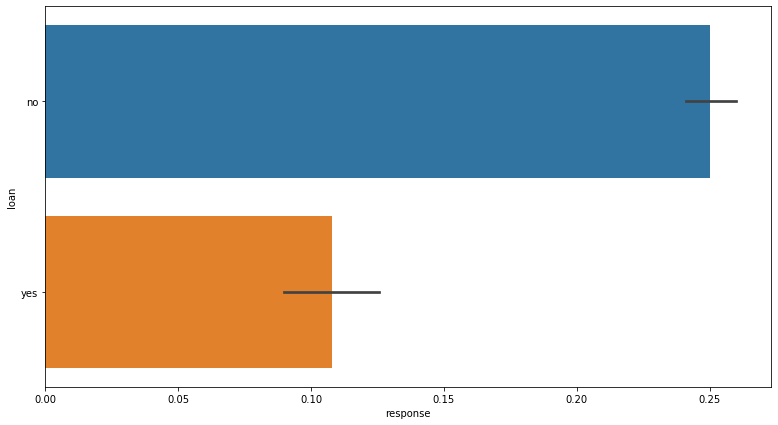

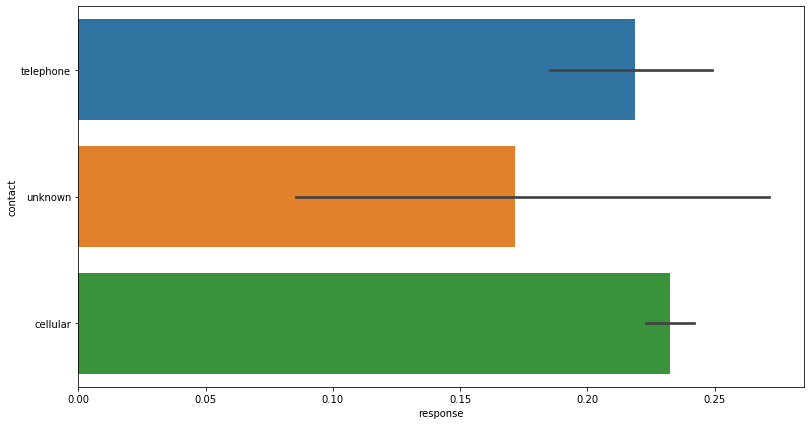

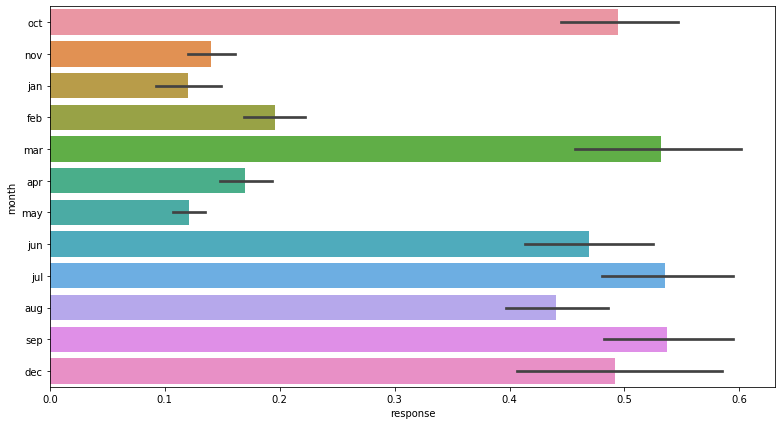

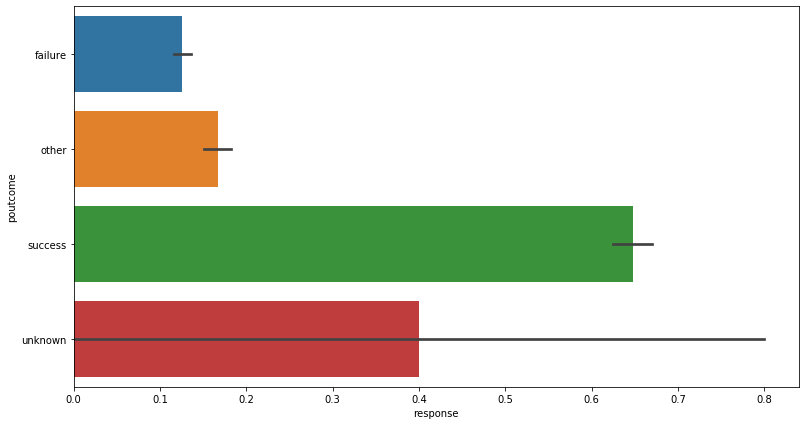

In [85]:
for i in cat_feature:
    plt.figure(figsize=(13,7))
    sn.barplot(df['response'], df[i])
    plt.show();

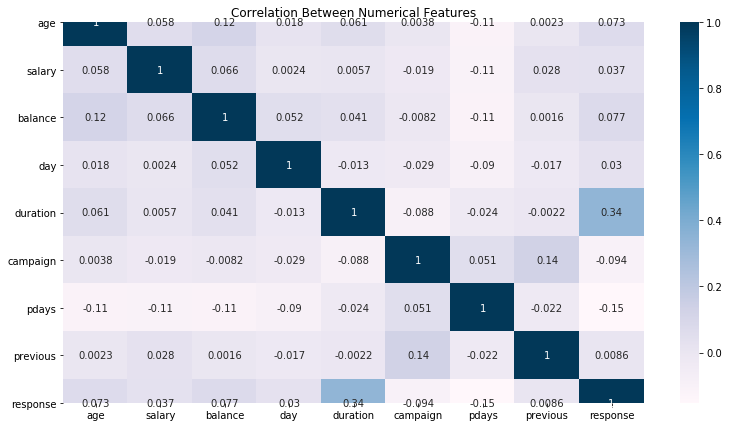

In [86]:
# Correlation
plt.figure(figsize=(13,7))
sn.heatmap(df.corr(),annot=True,cmap='PuBu')
plt.title("Correlation Between Numerical Features");

#### >>> We can see there is somewhat good positive correlation between response & duration means duration affect on target.

### Age-Wise Response

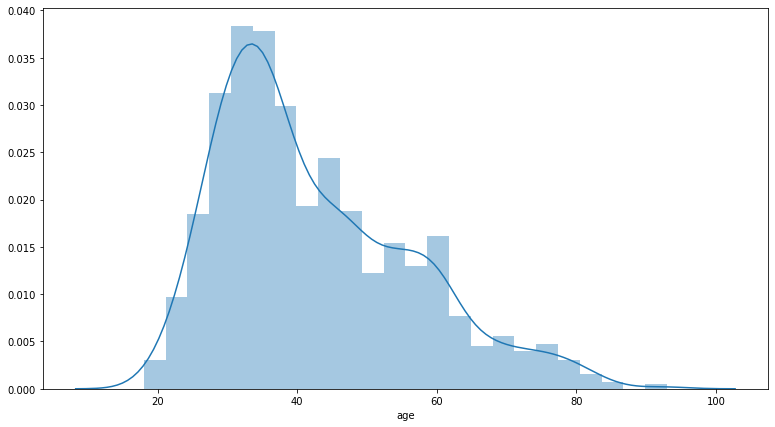

In [92]:
plt.figure(figsize=(13,7))
sn.distplot(df[df['response']==1].age);

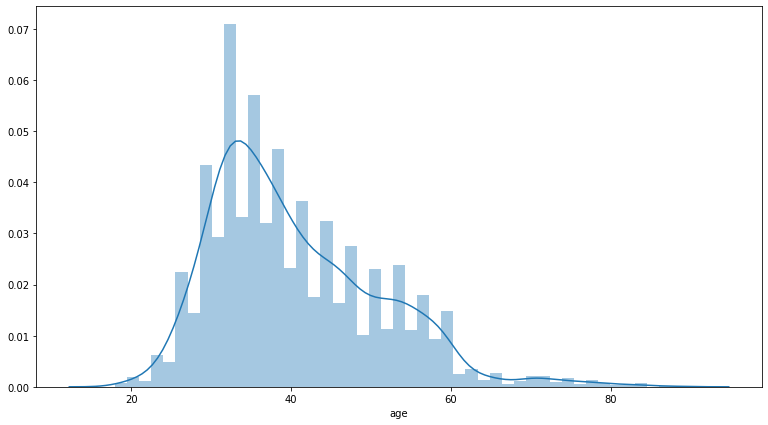

In [94]:
plt.figure(figsize=(13,7))
sn.distplot(df[df['response']==0].age);

### Are the features about the previous campaign data useful?
#### >>> Since, there is no such good correlation between the features. So the features about previous campaign data are somewhat useful.

### Are pdays and poutcome associated with the target? 
#### >>> Poutcome is the past data output so I don't think it will affect the target. Weak correlation is present between pdays and the target variable.

### If yes, and if you plan to use them – how do you handle the pdays column with a value of -1 where the previous campaign data is missing? Explain your approach and your decision
#### >>> Since, days can't be negative therefore dropping the rows where pdays is -1.

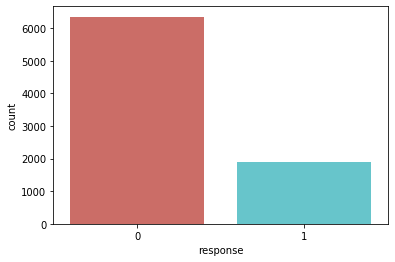

In [90]:
#dependent variable distribution (response vs. non response)
sn.countplot(x='response',data=df, palette='hls')
plt.show()

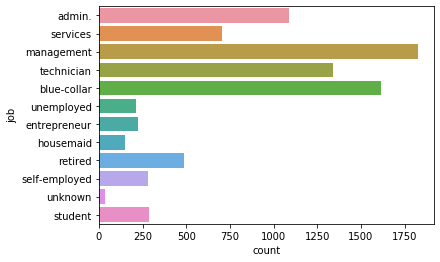

In [95]:
#Customer Job Distribution

sn.countplot(y="job", data=df)
plt.show()

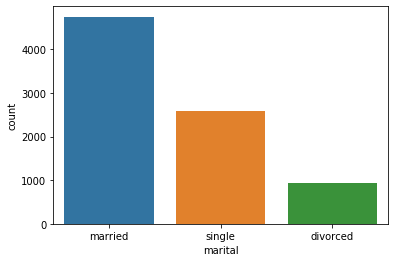

In [96]:
#Customer marital status distribution
sn.countplot(x="marital", data=df)
plt.show()

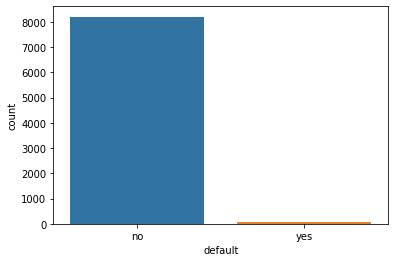

In [98]:
# Distribution of Default
sn.countplot(x="default", data=df)
plt.show()

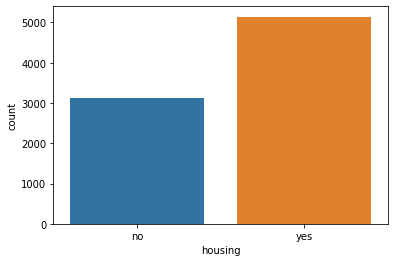

In [99]:
#house loan Distribution
sn.countplot(x="housing", data=df)
plt.show()

In [101]:
df.groupby('response').mean()

,age,salary,balance,day,duration,campaign,pdays,previous
response,,,,,,,,
0,40.499055,56923.803526,1427.837059,14.15932,215.990239,2.136650,234.191436,3.156014
1,42.467192,59698.687664,1987.159055,14.72231,407.259843,1.787927,192.521785,3.249344


##### Observations:
- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [102]:
df.groupby('job').mean()

,age,salary,balance,day,duration,campaign,pdays,previous,response
job,,,,,,,,,
admin.,39.297521,50000.0,1166.985308,14.124885,247.003673,1.932966,231.001837,3.189164,0.228650
blue-collar,39.444032,20000.0,1139.962894,14.068027,249.503401,2.204700,270.036487,3.040198,0.113791
entrepreneur,42.231111,120000.0,1234.195556,13.595556,273.880000,2.195556,220.306667,3.160000,0.120000
housemaid,48.138158,16000.0,1710.585526,15.203947,234.710526,2.144737,182.598684,3.032895,0.223684
management,40.276013,100000.0,1995.869660,14.437568,260.150602,2.025192,204.452355,3.460022,0.285871
retired,65.893443,55000.0,2706.448770,14.836066,325.764344,1.838115,177.354508,2.963115,0.422131
self-employed,39.750890,60000.0,2037.626335,14.366548,267.017794,1.946619,199.871886,3.099644,0.231317
services,38.495751,70000.0,1181.995751,13.546742,257.590652,2.101983,251.977337,2.949008,0.168555
student,26.614035,4000.0,1538.452632,14.796491,255.508772,2.161404,190.028070,3.136842,0.417544


In [103]:
df.groupby('marital').mean()

,age,salary,balance,day,duration,campaign,pdays,previous,response
marital,,,,,,,,,
divorced,46.227712,60494.092374,1507.401719,14.201933,261.815252,2.071966,233.911923,3.083781,0.197637
married,44.004847,57863.856691,1641.650369,14.179768,261.758693,2.064067,222.392624,3.191992,0.221286
single,33.440139,55955.831073,1418.882991,14.521891,256.491670,2.036033,225.227819,3.184812,0.259977


In [104]:
df.groupby('education').mean()

,age,salary,balance,day,duration,campaign,pdays,previous,response
education,,,,,,,,,
primary,47.211765,35627.450980,1430.891176,14.161765,271.438235,2.141176,248.065686,3.286275,0.169608
secondary,40.162906,48568.641279,1310.211801,14.146685,255.355195,2.068171,235.456982,3.096615,0.200987
tertiary,39.353383,81300.751880,1980.027820,14.472180,262.937218,2.005639,199.135714,3.310150,0.293609
unknown,44.770898,49829.721362,1718.684211,15.061920,263.897833,2.046440,216.643963,2.808050,0.297214


Text(0, 0.5, 'Frequency of Response')

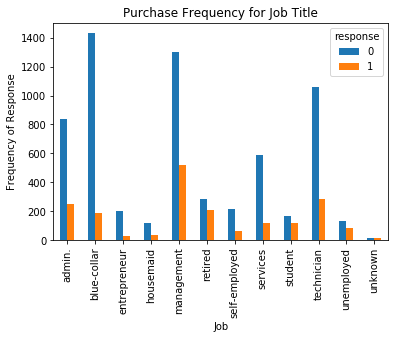

In [106]:
%matplotlib inline
pd.crosstab(df.job,df.response).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Response')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

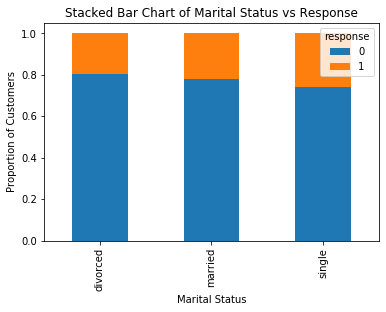

In [107]:
table=pd.crosstab(df.marital,df.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Response')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

The marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

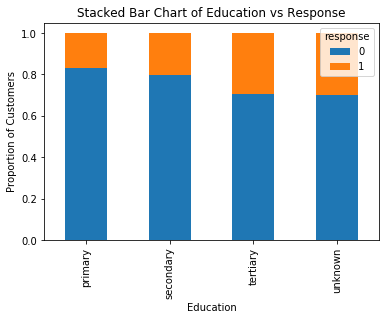

In [108]:
table=pd.crosstab(df.education,df.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Response')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

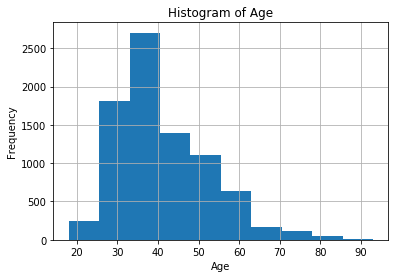

In [109]:
df.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the bank in this dataset are in the age range of 30–40.

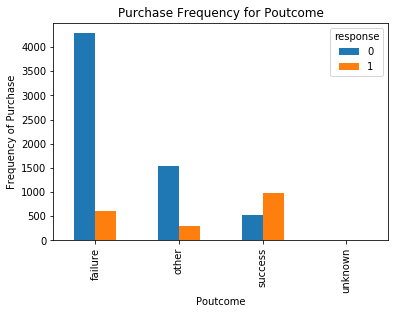

In [110]:
pd.crosstab(df.poutcome,df.response).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

### Creating Dummy Variables for Categorical Features

In [113]:
for c_feature in cat_feature:
    df_cat = create_dummies( df_cat, c_feature )

In [115]:
df_cat.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
24060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
24064,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24072,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
24077,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [116]:
df_final=df_num.join(df_cat)   # joining numerical and categorical variables

In [117]:
df_final

,age,salary,balance,day,duration,campaign,pdays,previous,response,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
24060,33,50000,882.0,21,39.0,1,151.0,3,0,0,...,0,0,0,0,0,1,0,0,0,0
24062,42,50000,-247.0,21,519.0,1,166.0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
24064,33,70000,3444.0,21,144.0,1,91.0,4,1,0,...,0,0,0,0,0,1,0,0,0,0
24072,36,100000,2415.0,22,73.0,1,86.0,4,0,0,...,0,0,0,0,0,1,0,1,0,0
24077,36,100000,0.0,23,140.0,1,143.0,3,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45199,34,20000,1475.0,16,1166.0,3,530.0,12,0,1,...,0,0,0,0,1,0,0,1,0,0
45201,53,100000,583.0,17,226.0,1,184.0,4,1,0,...,0,0,0,0,1,0,0,0,1,0
45204,73,55000,2850.0,17,300.0,1,40.0,8,1,0,...,0,0,0,0,1,0,0,0,0,0
45208,72,55000,5715.0,17,1127.0,5,184.0,3,1,0,...,0,0,0,0,1,0,0,0,1,0


In [118]:
#Splitting the data

feature_columns = df_final.columns.difference( ['response'] )
feature_columns

Index(['age', 'balance', 'campaign', 'contact_telephone', 'contact_unknown',
       'day', 'default_yes', 'duration', 'education_secondary',
       'education_tertiary', 'education_unknown', 'housing_yes',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'loan_yes', 'marital_married', 'marital_single', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'pdays', 'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'previous', 'salary', 'targeted_yes'],
      dtype='object')

In [119]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split( df_final[feature_columns],
                                                  df_final['response'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

### Building Logistic Regression Model

In [120]:
# Building Models
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit( train_X, train_y)

LogisticRegression()

In [124]:
#Predicting the test cases
df_final_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': logreg.predict( test_X ) } )

In [125]:
df_final_test_pred =df_final_test_pred.reset_index()

In [126]:
df_final_test_pred

,index,actual,predicted
0,37133,1,0
1,28420,0,0
2,40280,0,0
3,34811,0,0
4,33538,0,0
...,...,...,...
2473,25623,0,0
2474,25525,0,0
2475,35397,0,0
2476,40284,0,0


In [127]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( df_final_test_pred.actual,
                            df_final_test_pred.predicted, [1,0] )
cm

array([[ 108,  454],
       [ 101, 1815]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

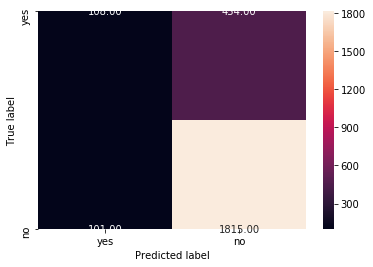

In [129]:
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["yes", "no"] , yticklabels = ["yes", "no"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [131]:
score = metrics.accuracy_score( df_final_test_pred.actual, df_final_test_pred.predicted )
round( float(score), 2 )

0.78

In [132]:
#How good the model is?
predict_proba_df_final = pd.DataFrame( logreg.predict_proba( test_X ) )
predict_proba_df_final.head()

,0,1
0,0.793903,0.206097
1,0.836505,0.163495
2,0.717810,0.282190
3,0.682594,0.317406
4,0.938368,0.061632


In [133]:
df_final_test_pred = pd.concat( [df_final_test_pred, predict_proba_df_final], axis = 1 )

In [134]:
df_final_test_pred.columns = ['index', 'actual', 'predicted', 'respond_0', 'respond_1']

In [136]:
auc_score = metrics.roc_auc_score( df_final_test_pred.actual, df_final_test_pred.respond_1  )
round( float( auc_score ), 2 )

0.74

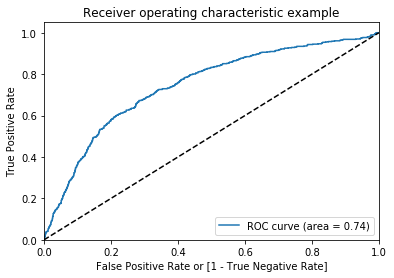

In [137]:
# Finding the optimal cutoff probability
fpr, tpr, thresholds = metrics.roc_curve( df_final_test_pred.actual,
                                     df_final_test_pred.respond_1,
                                     drop_intermediate = False )

plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [138]:
tpr[np.abs(tpr - 0.7).argmin()]

0.699288256227758

In [139]:
cutoff_prob = thresholds[(np.abs(tpr - 0.699982099170595)).argmin()]

In [140]:
round( float( cutoff_prob ), 2 )

0.23

In [143]:
#Predicting with new cut-off probability
df_final_test_pred['new_labels'] = df_final_test_pred['respond_1'].map( lambda x: 1 if x >= 0.23 else 0 )

In [144]:
metrics.accuracy_score( df_final_test_pred.actual, df_final_test_pred['new_labels'])

0.6807909604519774

In [146]:
auc_score = metrics.roc_auc_score( df_final_test_pred.actual, df_final_test_pred['new_labels'])
round( float( auc_score ), 2 )

0.69

[[ 394  168]
 [ 623 1293]]


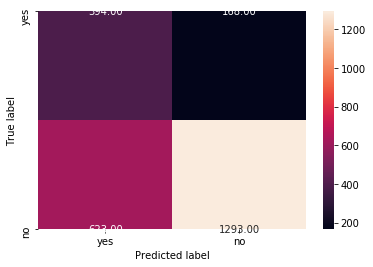

In [148]:
cm = metrics.confusion_matrix( df_final_test_pred.actual,
                          df_final_test_pred.new_labels, [1,0] )
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["yes", "no"] , yticklabels = ["yes", "no"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

### BUILDING RANDOM FOREST MODEL

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [153]:
pargrid_rf = {'n_estimators': [50, 60, 70, 80, 90, 100],
                  'max_features': [5,6,7,8,9,10,11,12]}

#from sklearn.grid_search import GridSearchCV
gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_rf, 
                        cv=10,
                        verbose=True, n_jobs=-1)

gscv_results = gscv_rf.fit(train_X, train_y)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [154]:
gscv_results.best_params_

{'max_features': 8, 'n_estimators': 80}

In [155]:
gscv_rf.best_score_

0.8543030710092172

In [160]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=80, max_features=8, n_jobs=-1)
radm_clf.fit( train_X, train_y )

RandomForestClassifier(max_features=8, n_estimators=80, n_jobs=-1,
                       oob_score=True)

In [161]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [162]:
print(metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted ))
print(metrics.roc_auc_score( radm_test_pred.actual, radm_test_pred.predicted ))

0.8482647296206618
0.7459565078492412


Text(0.5, 15.0, 'Predicted label')

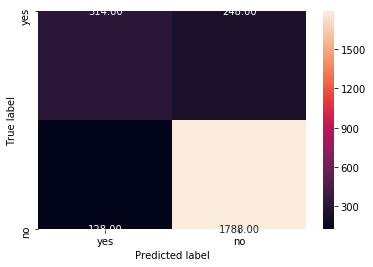

In [163]:
tree_cm = metrics.confusion_matrix( radm_test_pred.actual,
                                 radm_test_pred.predicted,
                                 [1,0] )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["yes", "no"] , yticklabels = ["yes", "no"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Feature importance from the Random Forest Model

In [164]:
print(radm_clf.feature_importances_)
print(np.argsort(radm_clf.feature_importances_))

[6.49318536e-02 7.14820355e-02 2.52663201e-02 5.13989633e-03
 1.93563616e-03 6.63651316e-02 9.40390398e-04 2.04014373e-01
 9.34662731e-03 8.98849179e-03 4.09503443e-03 4.53720293e-02
 8.45433873e-03 2.33556505e-03 2.61948865e-03 7.48098764e-03
 4.39703546e-03 3.15696450e-03 4.48781857e-03 2.56701004e-03
 8.33690091e-03 2.78446787e-03 5.16865520e-04 8.36060803e-03
 9.33495776e-03 9.05862924e-03 9.57202789e-03 3.21806081e-03
 8.05086487e-03 6.01612325e-03 7.03303601e-03 8.36497939e-03
 8.03087119e-03 1.30646033e-02 1.11103179e-02 8.76162606e-03
 8.39873475e-03 1.11087533e-01 1.00883040e-02 1.33587397e-01
 1.86715481e-04 3.74067021e-02 2.68671675e-02 7.38547798e-03]
[40 22  6  4 13 19 14 21 17 27 10 16 18  3 29 30 43 15 32 28 20 23 31 36
 12 35  9 25 24  8 26 38 34 33  2 42 41 11  0  5  1 37 39  7]


In [165]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]

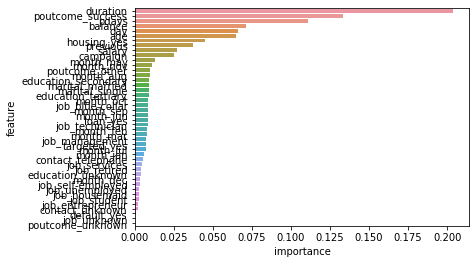

In [166]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

### Gradient Boosting

In [167]:
from sklearn.ensemble import GradientBoostingClassifier

In [168]:
pargrid_gbm = {'n_estimators': [350,400,450,500],
               'learning_rate': [10 ** x for x in range(-3, 1)],
                'max_features': [7,8,9,10,11,12]}

In [169]:
from sklearn.model_selection import GridSearchCV
gscv_gbm = GridSearchCV(estimator=GradientBoostingClassifier(), 
                        param_grid=pargrid_gbm, 
                        cv=5,
                        verbose=True, n_jobs=-1)

In [170]:
gscv_gbm.fit(train_X, train_y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_features': [7, 8, 9, 10, 11, 12],
                         'n_estimators': [350, 400, 450, 500]},
             verbose=True)

In [171]:
gscv_gbm.best_params_

{'learning_rate': 0.1, 'max_features': 12, 'n_estimators': 400}

In [172]:
gbm = gscv_gbm.best_estimator_

In [173]:
gscv_gbm.best_score_

0.8551670935753981

In [174]:
gbm.fit(train_X, train_y )

GradientBoostingClassifier(max_features=12, n_estimators=400)

In [175]:
print(metrics.accuracy_score(test_y,gbm.predict(test_X)))
print(metrics.roc_auc_score(test_y,gbm.predict(test_X)))

0.8535108958837773
0.7751264868238249


Text(0.5, 15.0, 'Predicted label')

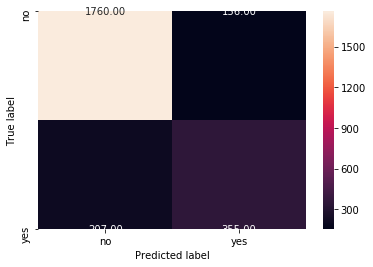

In [241]:
gbm_cm = metrics.confusion_matrix( test_y,gbm.predict(test_X) )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["no", "yes"] , yticklabels = ["no", "yes"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Xtreme Gradient Boosting

In [176]:
from xgboost import XGBClassifier

In [177]:
pargrid_xgbm = {'n_estimators': [200, 250, 300, 400, 500],
               'learning_rate': [10 ** x for x in range(-3, 1)],
                'max_features': [5,6,7,8,9,10]}

In [178]:
#from sklearn.model_selection import GridSearchCV
gscv_xgbm = GridSearchCV(estimator=XGBClassifier(), 
                        param_grid=pargrid_xgbm, 
                        cv=5,
                        verbose=True, n_jobs=-1)

In [179]:
gscv_xgbm.fit(train_X, train_y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[19:45:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [180]:
gscv_xgbm.best_params_

{'learning_rate': 0.01, 'max_features': 5, 'n_estimators': 500}

In [181]:
xgbm = gscv_xgbm.best_estimator_

In [182]:
gscv_gbm.best_score_

0.8551670935753981

In [183]:
xgbm.fit(train_X, train_y)

[19:45:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6, max_features=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [184]:
print(metrics.accuracy_score(test_y,xgbm.predict(test_X)))
print(metrics.roc_auc_score(test_y,xgbm.predict(test_X)))

0.8490718321226796
0.7521369029487588


Text(0.5, 15.0, 'Predicted label')

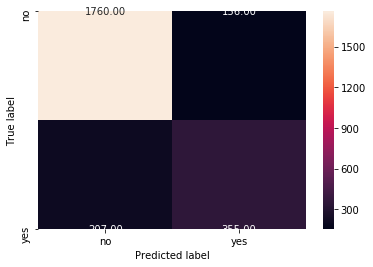

In [240]:
xgbm_cm = metrics.confusion_matrix( test_y,xgbm.predict(test_X) )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["no", "yes"] , yticklabels = ["no", "yes"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### To implent distance based algorithm, we need to standardised the data.

##### Feature Selection
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [186]:
df_final_vars=df_final.columns.values.tolist()
y=['response']
X=[i for i in df_final_vars if i not in y]

In [188]:
from sklearn import datasets
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)

#15,20,25

rfe = rfe.fit(df_final[X], df_final[y])

print(rfe.support_)
print(rfe.ranking_)


[False False False False False False False False  True  True False False
 False False False False False  True  True False False False False False
 False False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False  True  True]
[21 25 24 18 22  7 23 17  1  1  6  5  4 16 19  3 15  1  1 12 13 10  8 20
 11 14  1  1  1  1  1  1  9  1  1  1  1  1  1  1  1  2  1  1]


In [192]:
X_all=df_final.drop(columns='response')
cols=X_all.columns[rfe.support_]


X=df_final[cols]
y=df_final['response']

### Implementing the model

In [193]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_scaled=pd.DataFrame(sc.fit_transform(X))

X_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.493482,-0.167371,-0.162725,-0.063345,-1.284804,-0.396756,3.476432,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,-0.402259,4.810746,-0.198496,-0.473270,-0.024615
1,-0.493482,-0.167371,-0.162725,-0.063345,0.778329,2.520442,3.476432,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,-0.402259,4.810746,-0.198496,-0.473270,-0.024615
2,-0.493482,-0.167371,-0.162725,-0.063345,0.778329,-0.396756,3.476432,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,-0.402259,4.810746,-0.198496,-0.473270,-0.024615
3,-0.493482,-0.167371,-0.162725,-0.063345,0.778329,-0.396756,3.476432,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,-0.402259,4.810746,-0.198496,-0.473270,-0.024615
4,-0.493482,-0.167371,-0.162725,-0.063345,0.778329,-0.396756,3.476432,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,-0.402259,4.810746,-0.198496,-0.473270,-0.024615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252,2.026418,-0.167371,-0.162725,-0.063345,0.778329,-0.396756,-0.287651,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,2.485961,-0.207868,-0.198496,-0.473270,-0.024615
8253,-0.493482,-0.167371,-0.162725,-0.063345,-1.284804,-0.396756,-0.287651,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,2.485961,-0.207868,-0.198496,2.112958,-0.024615
8254,-0.493482,-0.167371,-0.162725,-0.063345,-1.284804,-0.396756,-0.287651,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,2.485961,-0.207868,-0.198496,-0.473270,-0.024615
8255,-0.493482,-0.167371,-0.162725,-0.063345,-1.284804,-0.396756,-0.287651,-0.092467,-0.262162,-0.120408,-0.253345,-0.178152,-0.201444,-0.146288,-0.661627,2.485961,-0.207868,-0.198496,2.112958,-0.024615


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

### KNN

In [196]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import GridSearchCV

In [212]:
tuned_parameters = [{'n_neighbors': [13,14,15,16,17,18,19,20]}]

knn_clf = GridSearchCV(KNeighborsClassifier(),
                   tuned_parameters,
                   cv=5,
                scoring='roc_auc',
                      n_jobs=-1)

In [213]:
knn_clf.fit(X_train, y_train )

knn_clf.best_score_

0.7995273798215737

In [214]:
knn_clf.predict( X_train )

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [215]:
metrics.roc_auc_score( y_train, knn_clf.predict( X_train ))

0.691022134966095

In [216]:
knn_clf.best_params_

{'n_neighbors': 19}

In [218]:
#Building for the n_neighbors=19
knn_clf = KNeighborsClassifier( n_neighbors =19 )

In [219]:
knn_clf.fit( X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [227]:
knn_cm = metrics.confusion_matrix( y_test, knn_clf.predict( X_test ) )

Text(0.5, 15.0, 'Predicted label')

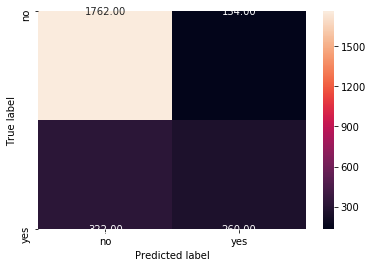

In [239]:
sn.heatmap(knn_cm, annot=True,  fmt='.2f', xticklabels = ["no", "yes"] , yticklabels = ["no", "yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [229]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_clf.predict( X_test )))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1896
           1       0.66      0.45      0.53       582

    accuracy                           0.82      2478
   macro avg       0.75      0.69      0.71      2478
weighted avg       0.80      0.82      0.80      2478



In [230]:
accuracy=metrics.accuracy_score( y_test, knn_clf.predict( X_test ) )
AUC=metrics.roc_auc_score( y_test, knn_clf.predict( X_test ))

print("KNN model accuracy: %.3f" % (accuracy))
print("KNN model AUC: %.3f" % (AUC))

KNN model accuracy: 0.816
KNN model AUC: 0.688
